A time series is a sequence of data points measured or recorded over successive and equally spaced time intervals. It's a fundamental concept in various fields, including economics, finance, engineering, environmental science, and more. Time series data captures how a certain quantity or variable changes over time, allowing us to analyze trends, patterns, and fluctuations in that data.

Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. Time series forecasting is the use of a model to predict future values based on previously observed values.

Time series are widely used for non-stationary data, like economic, weather, stock price, and retail sales in this post.

In [29]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

We are going to do time series analysis and forecasting for furniture sales.

In [30]:
df = pd.read_excel("Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

In [31]:
furniture.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


We have a good 4-year furniture sales data. 

In [32]:
furniture['Order Date'].min()

Timestamp('2014-01-06 00:00:00')

In [33]:
furniture['Order Date'].max()

Timestamp('2017-12-30 00:00:00')

## Data preprocessing

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [34]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')

In [35]:
furniture.head()

,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940


In [36]:
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [37]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [38]:
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


## Indexing with time series data

In [39]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [40]:
y = furniture['Sales'].resample('MS').mean()

In [41]:
furniture['Sales']

Order Date
2014-01-06    2573.8200
2014-01-07      76.7280
2014-01-10      51.9400
2014-01-11       9.9400
2014-01-13     879.9390
                ...    
2017-12-24    1393.4940
2017-12-25     832.4540
2017-12-28     551.2568
2017-12-29    2330.7180
2017-12-30     323.1360
Name: Sales, Length: 889, dtype: float64

Have a quick peek 2017 sales data.

In [42]:
y['2014':'2015']

Order Date
2014-01-01     480.194231
2014-02-01     367.931600
2014-03-01     857.291529
2014-04-01     567.488357
2014-05-01     432.049188
2014-06-01     695.059242
2014-07-01     601.169500
2014-08-01     457.521656
2014-09-01     992.353367
2014-10-01     769.015437
2014-11-01     980.221486
2014-12-01    1532.298325
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412012
2015-09-01    1382.790684
2015-10-01     632.980184
2015-11-01    1286.701354
2015-12-01    1049.355418
Freq: MS, Name: Sales, dtype: float64

## Time series seasonality

Time series seasonality refers to a recurring pattern or behavior that repeats at regular intervals within a time series data. A time series is a sequence of data points measured or recorded over successive and equally spaced time intervals. Seasonality is one of the components that can be present in a time series, along with trend, noise, and cyclic patterns.

Seasonality is often influenced by external factors like the time of year, holidays, weather conditions, and other periodic events. It manifests as a consistent and predictable pattern that repeats over time. Identifying and understanding seasonality in a time series is crucial for making accurate forecasts and analyzing underlying trends.

There are two main types of seasonality patterns:

Additive Seasonality: In an additive seasonality pattern, the fluctuations have a consistent magnitude regardless of the overall trend level. For example, in retail sales data, if the sales increase by a certain amount every December due to the holiday season, the increase remains relatively constant from year to year, even if the overall sales trend is increasing or decreasing.

Multiplicative Seasonality: In a multiplicative seasonality pattern, the fluctuations' magnitude is proportional to the trend level. This means that if the trend is higher, the seasonal fluctuations will also be larger. This pattern is common in phenomena where the seasonality effect becomes more pronounced as the overall magnitude of the data increases. For instance, in tourism data, the number of visitors during holiday seasons might increase by a certain percentage each year, and this percentage increase remains relatively constant.

Detecting seasonality involves various methods, including visual inspection of the data, statistical techniques, and more advanced time series analysis techniques. Popular approaches for identifying and dealing with seasonality include:

* Seasonal Decomposition: This involves breaking down the time series into its constituent components, namely trend, seasonality, and residual (noise). Techniques like additive and multiplicative decomposition can help extract and analyze the seasonal patterns.

* Autocorrelation Function (ACF): ACF measures the correlation between a time series and a lagged version of itself. Peaks in the ACF plot at specific lags can indicate the presence of seasonality.

* Seasonal Subseries Plot: This involves creating subplots for different seasonal periods to visualize the repeated patterns within each season.

* Box-Jenkins Methodology: This method involves using techniques like ARIMA (AutoRegressive Integrated Moving Average) models to model and forecast time series data, which can capture seasonality as well.

* Fourier Analysis: Fourier analysis can be used to analyze and quantify periodic components in time series data, including seasonality.


#### Time series decomposition 

Time series decomposition is a method used to break down a time series into its underlying components: trend, seasonality, and noise (or residuals). This technique helps in understanding the different patterns present in the time series data and can provide insights into its behavior over time. By decomposing a time series, you can more easily identify the individual influences of these components and make more informed analyses or forecasts.

Here's a breakdown of the three components:

1. **Trend:** The trend component represents the long-term movement or direction of the time series data. It indicates whether the data is increasing, decreasing, or remaining relatively constant over time. Trends can be linear, nonlinear, or even exhibit sudden changes. Identifying the trend component is essential for understanding the overall behavior and direction of the data.

2. **Seasonality:** The seasonality component captures repeating patterns or fluctuations that occur at fixed intervals within the time series. These intervals might correspond to seasons, months, weeks, days, or any other regular time period. Seasonality can be caused by external factors like weather, holidays, or cultural events. Detecting seasonality helps in understanding the periodic variations in the data and predicting when similar patterns will recur in the future.

3. **Noise (Residuals):** The noise component, also known as residuals or errors, represents the random fluctuations or irregularities that cannot be explained by the trend or seasonality. It includes any unpredictable variations, measurement errors, and other factors that contribute to the volatility of the data. Noise is essentially the difference between the observed data and the sum of the trend and seasonality components.

Time series decomposition methods, such as additive and multiplicative decomposition, aim to separate these components to provide a clearer picture of the underlying patterns. The choice between additive and multiplicative decomposition depends on whether the magnitude of the seasonality fluctuations remains constant (additive) or changes proportionally with the trend (multiplicative).


## Visualizing furniture sales time series data

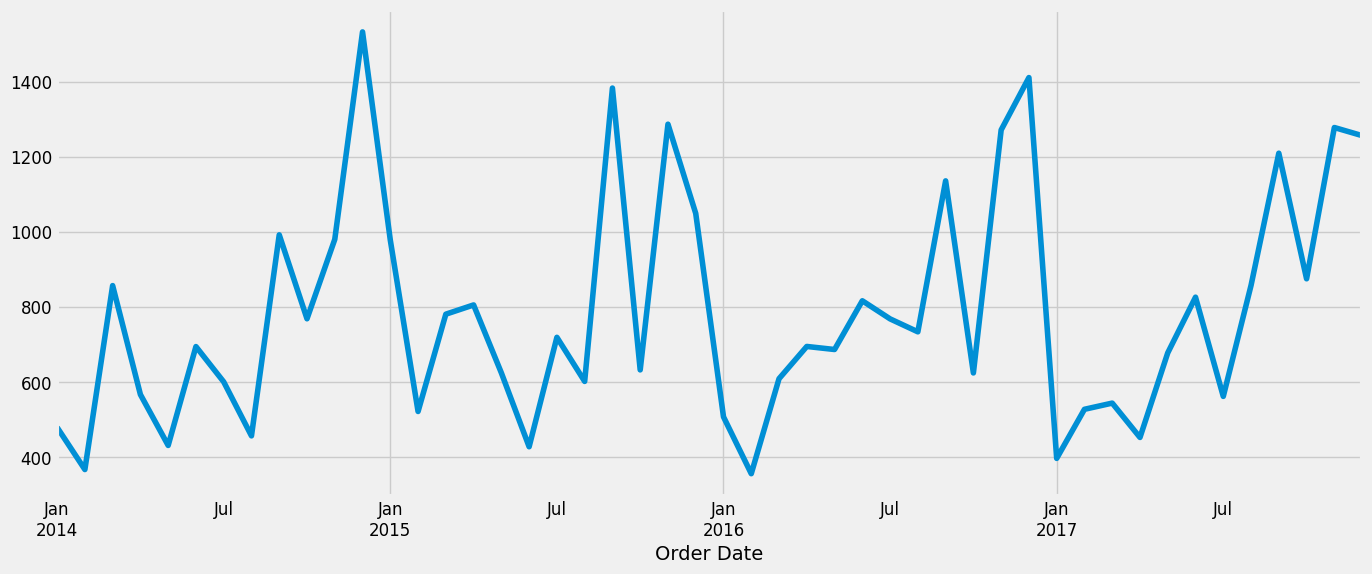

In [43]:
y.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always a strong upward trend within any single year with a couple of low months in the mid of the year.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

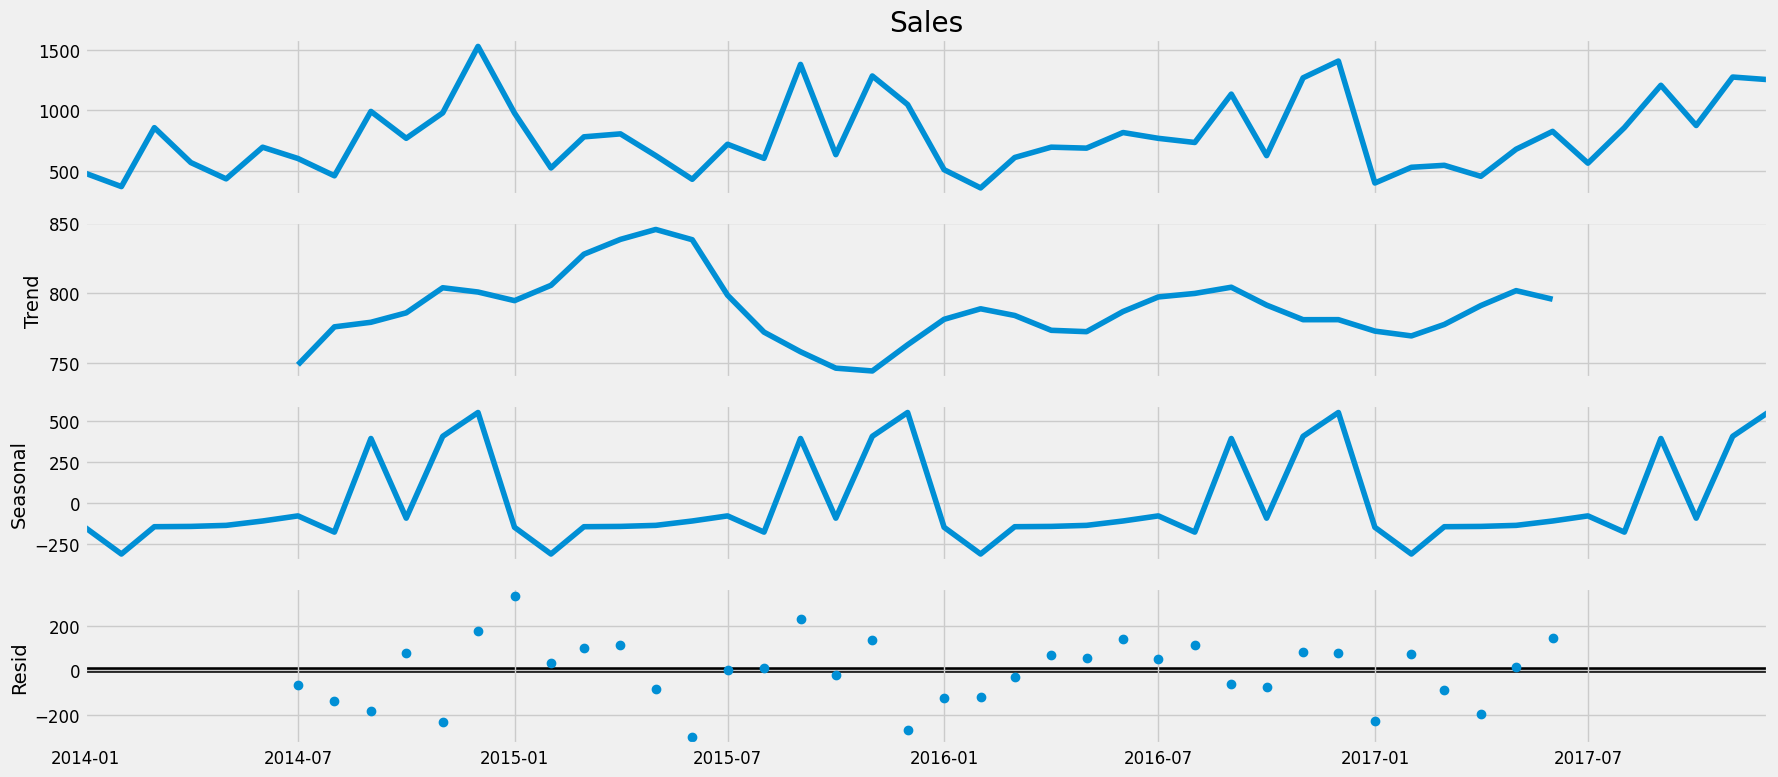

In [44]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality./

## Time series forecasting with ARIMA

Time Series forecasting with ARIMA (AutoRegressive Integrated Moving Average) is a widely used statistical method for predicting future values of a time series data based on its historical patterns. ARIMA models are particularly effective for time series data that exhibit temporal dependencies, such as trends and seasonality. The acronym ARIMA stands for AutoRegressive Integrated Moving Average:

- **AutoRegressive (AR):** This component models the relationship between a current value and its past values. It captures the effect of previous observations on the current observation. An AR(p) model uses the past p observations to predict the next value.

- **Integrated (I):** This component deals with making the time series stationary. Stationarity means that the statistical properties of the time series, such as mean and variance, do not change over time. If the time series is not stationary, differencing can be applied to make it stationary. The order of differencing is denoted by the parameter d.

- **Moving Average (MA):** This component models the relationship between a current value and past forecast errors. It captures the effect of previous forecast errors on the current observation. An MA(q) model uses the past q forecast errors to predict the next value.

ARIMA models are defined by three main parameters: p, d, and q.

- **p (AR Order):** The number of lagged observations used for the auto-regressive component. It indicates how far back in time you're looking for dependencies.

- **d (Integration Order):** The number of differencing operations needed to make the time series stationary. It represents the degree of differencing required.

- **q (MA Order):** The number of lagged forecast errors used for the moving average component. It indicates how far back in time you're looking for dependencies in forecast errors.

For example, an ARIMA(2,1,1) model has an autoregressive order of 2, a differencing order of 1, and a moving average order of 1. This means it uses the past two values and the past one forecast error to predict the current value, while also performing one level of differencing to make the data stationary.

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

Parameter Selection for the ARIMA Time Series Model

In [45]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


The SARIMA model is an extension of the ARIMA model that takes into account seasonality in addition to autoregressive and moving average components. The p, d, and q values correspond to the non-seasonal autoregressive, differencing, and moving average orders, respectively. The seasonal component is determined by the fourth value, which is the seasonal period (in this case, 12 for months).

SARIMA (Seasonal AutoRegressive Integrated Moving Average) is an extension of the ARIMA model that incorporates seasonality in time series data. It's used for forecasting time series data that exhibits both non-seasonal and seasonal patterns. SARIMA models are particularly useful when the data displays repeating patterns at regular intervals, such as daily, monthly, or yearly cycles.

A SARIMA model is defined by the combination of parameters `(p, d, q) × (P, D, Q, s)`:

1. **p (AutoRegressive Order):** The same as in the non-seasonal ARIMA model. It represents the number of lagged observations of the dependent variable included in the model's autoregressive component.

2. **d (Differencing Order):** The same as in the non-seasonal ARIMA model. It represents the number of times the data is differenced to achieve stationarity.

3. **q (Moving Average Order):** The same as in the non-seasonal ARIMA model. It represents the number of lagged forecast errors of the dependent variable included in the model's moving average component.

4. **P (Seasonal AutoRegressive Order):** This parameter introduces the seasonal autoregressive component, similar to the AR component but applied to the seasonal pattern. It represents the number of seasonal lagged observations used to predict the current value.

5. **D (Seasonal Differencing Order):** This parameter introduces the seasonal differencing component, similar to the non-seasonal differencing but applied to the seasonal pattern. It represents the number of times the seasonal data is differenced to achieve seasonally stationary data.

6. **Q (Seasonal Moving Average Order):** This parameter introduces the seasonal moving average component, similar to the MA component but applied to the seasonal pattern. It represents the number of seasonal lagged forecast errors used to predict the current value.

7. **s (Seasonal Period):** This parameter specifies the length of the seasonal cycle. For example, if the data follows a yearly cycle, `s` would be 12 for monthly data (12 months in a year).

The "seasonal factor" you mentioned likely refers to the impact of seasonality on the time series data. Seasonality is a repeating pattern that occurs at regular intervals, and it can significantly influence the data's behavior. A seasonal factor represents the effect of the seasonal component on the time series. In a SARIMA model, the seasonal factors (represented by the seasonal AR, MA, and differencing components) capture the repeating patterns and help improve the model's accuracy when forecasting data with strong seasonal variations.

SARIMA models are powerful tools for forecasting time series data that displays both non-seasonal and seasonal patterns. They account for various levels of autocorrelation, trend, and seasonality in the data, making them suitable for a wide range of applications, from economics to climate science.

Here now we are performing a grid search to find the best parameter combinations for a Seasonal ARIMA (SARIMA) model based on the Akaike Information Criterion (AIC). The AIC is a measure that balances the goodness of fit of a model with its complexity, helping to select a model that provides a good trade-off between accuracy and simplicity.  Lower AIC values indicate better models.

In [46]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1457.5412534942598
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130919703
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.27028997935736
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418338
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1179.6903776415356
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.24882803033336
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758095
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2621.5327370301484
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091517
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.62613896732915
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.5634719720483
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2556.28914808803
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946868
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.8725576454926
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.8947668259312
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1295.1066017507496
ARI

In [47]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0,0,0),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.7620      0.763     -0.999      0.318      -2.257       0.733
sigma2      3.273e+04   2.46e+04      1.333      0.183   -1.54e+04    8.09e+04


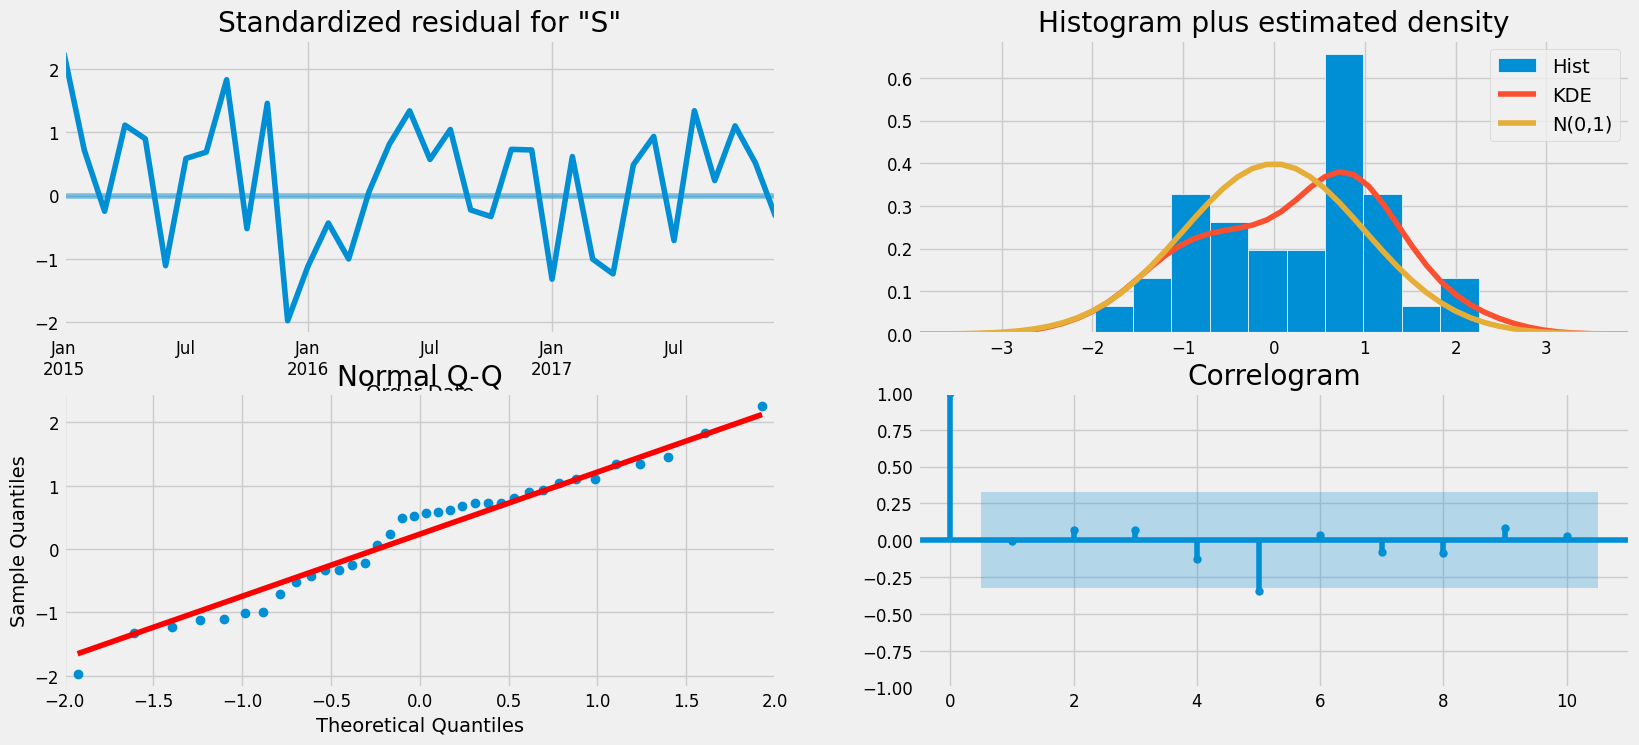

In [48]:
results.plot_diagnostics()
plt.show()

Standardized Residuals Plot: This subplot displays the standardized residuals over time. Residuals are the differences between the actual and predicted values. In a well-fitted model, residuals should appear as random noise with no clear patterns, indicating that the model captures the underlying patterns in the data.

Histogram plus Estimated Density: This subplot shows a histogram of the residuals along with an estimated density curve. It helps you assess whether the residuals follow a normal distribution. If the residuals are normally distributed, they should roughly align with the density curve.

Normal Q-Q (Quantile-Quantile) Plot: The Normal Q-Q plot compares the quantiles of the standardized residuals against the quantiles of a theoretical normal distribution. If the residuals follow a normal distribution, the points on the plot should lie approximately along a straight line.

Correlogram (ACF - AutoCorrelation Function) of Residuals: This subplot displays the autocorrelation function of the residuals. It helps you identify any remaining patterns or correlations in the residuals. In an ideal situation, there should be no significant autocorrelation, indicating that the model effectively captures the temporal dependencies.

## Validating forecasts

To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017-07-01 to the end of the data.

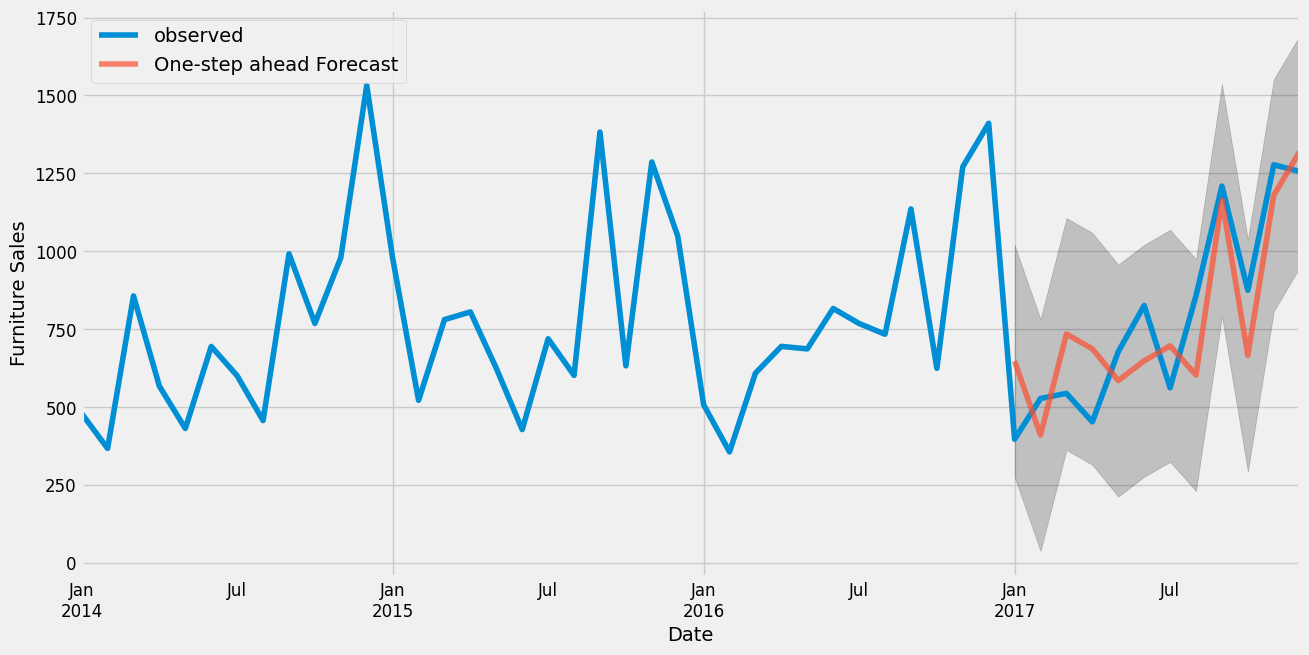

In [49]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

In [50]:
pred_ci

,lower Sales,upper Sales
Order Date,,
2017-01-01,275.933249,1019.851392
2017-02-01,39.077162,782.995304
2017-03-01,362.932339,1106.850481
2017-04-01,315.638029,1059.556171
2017-05-01,213.611446,957.529589
2017-06-01,277.037828,1020.955970
2017-07-01,325.063231,1068.981373
2017-08-01,231.356079,975.274221
2017-09-01,792.331684,1536.249826


In [52]:
pred.predicted_mean

Order Date
2017-01-01     647.892320
2017-02-01     411.036233
2017-03-01     734.891410
2017-04-01     687.597100
2017-05-01     585.570518
2017-06-01     648.996899
2017-07-01     697.022302
2017-08-01     603.315150
2017-09-01    1164.290755
2017-10-01     666.187260
2017-11-01    1179.684507
2017-12-01    1320.233014
Freq: MS, Name: predicted_mean, dtype: float64

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year.

In [53]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 29162.52


In [54]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 170.77


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200. Hence, this is a pretty good model so far.

## Producing and visualizing forecasts

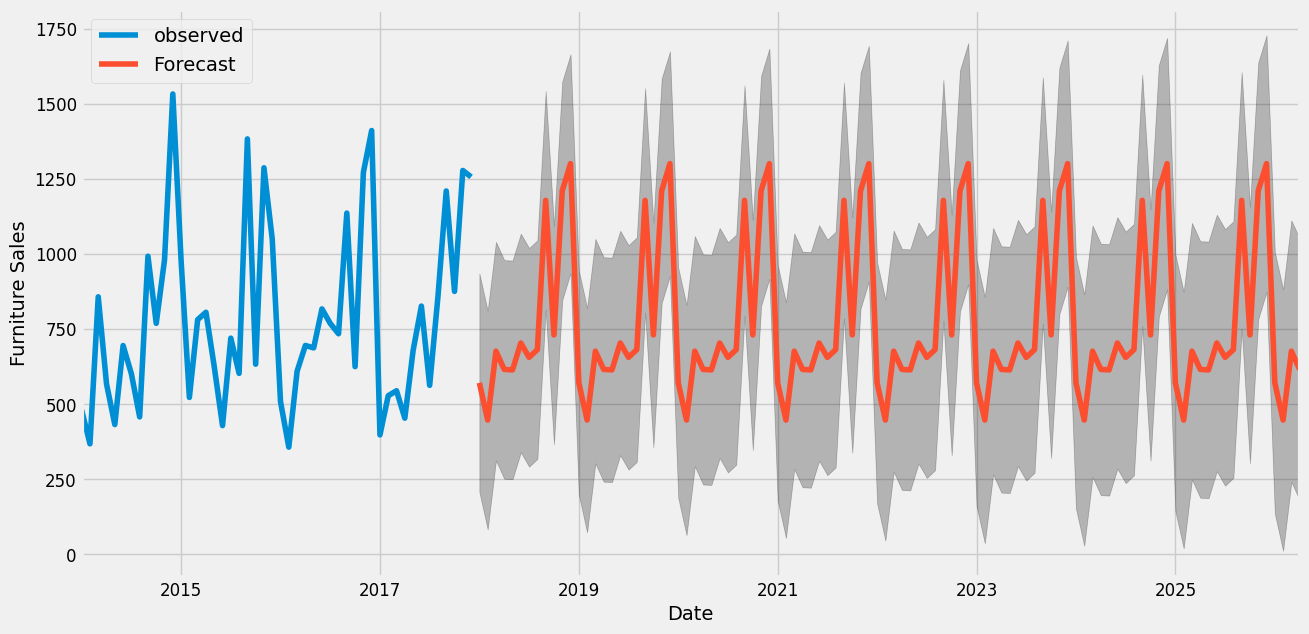

In [55]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

Our model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.